# Intro Task, Object Localization 

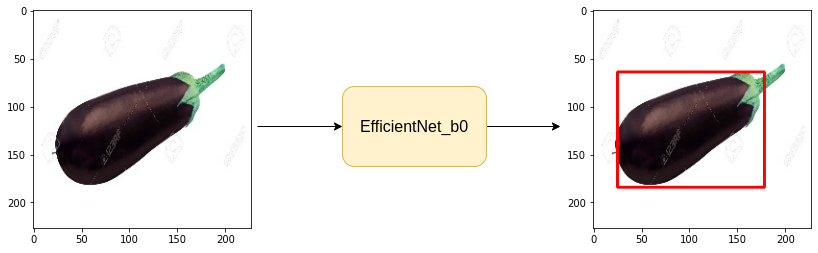

In [ ]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-am_hk5is
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-am_hk5is
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=123546 sha256=61b1dae1cbf8bf16db85b51871fa05a84a699b6a5bab8a6ec85f111cee2ef812
  Stored in directory: /tmp/pip-ephem-wheel-cache-9nsye67f/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 34.3 MB/s 
Looking in indexes: https

In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

Cloning into 'object-localization-dataset'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 203 (delta 3), reused 195 (delta 0), pack-reused 0
Receiving objects: 100% (203/203), 2.73 MiB | 1.98 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = "/content/object-localization-dataset/train.csv"
DATA_DIR = "/content/object-localization-dataset/"
DEVICE = "cuda"

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = "efficientnet_b0"
NUM_COR = 4 # number of coordinates


In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant


# Understand the dataset

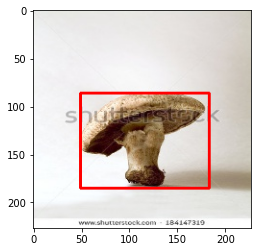

In [ ]:
row =df.iloc[2]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
pt1 = (row.xmin,row.ymin)
pt2 = (row.xmax,row.ymax)
bnd_box_img = cv2.rectangle(img,pt1,pt2,(255,0,0),2)
plt.imshow(img)

In [ ]:
train_df,valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
],bbox_params = A.BboxParams(format = "pascal_voc", label_fields = ["class_labels"]))



valid_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
],bbox_params = A.BboxParams(format = "pascal_voc", label_fields = ["class_labels"]))

# Create Custom Dataset

In [ ]:
class ObjLocDataset(torch.utils.data.Dataset):
  def __init__(self,df,augmentations = None):
    self.df = df
    self.augmentations = augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax
    bbox = [[xmin,ymin,xmax,ymax]]
    img_path = DATA_DIR +row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    if self.augmentations:
      data = self.augmentations(image = img,bboxes = bbox,class_labels = [None])
      img = data["image"]
      bbox = data["bboxes"][0]
    img = torch.from_numpy(img).permute(2,0,1)/255.0 # (h,w,c) --> (c,h,w)
    bbox = torch.Tensor(bbox)
    return img, bbox


In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)


In [ ]:
print(f"Total example in the trainset : {len(trainset)}")
print(f"Total example in the validset : {len(validset)}")

Total example in the trainset : 148
Total example in the validset : 38


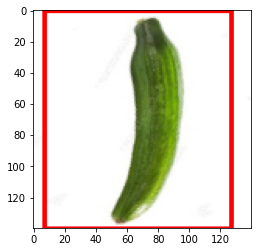

In [ ]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle = True)
validloader = torch.utils.data.DataLoader(validset,batch_size = BATCH_SIZE, shuffle = False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn 
import timm

In [ ]:
class ObjLocModel(nn.Module):
  def __init__(self):
    super(ObjLocModel,self).__init__()
    self.backbone = timm.create_model(MODEL_NAME,pretrained = True, num_classes =4)
  def forward(self,images,gt_bboxes = None):
    bboxes = self.backbone(images) #logits
    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes,gt_bboxes)
      return bboxes, loss
    return bboxes


In [ ]:
model = ObjLocModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):
  total_loss = 0.0
  model.train() # Dropout ON
  for data in tqdm(dataloader):
    images,gt_bboxes = data
    images,gt_bboxes = images.to(DEVICE),gt_bboxes.to(DEVICE)
    bboxes, loss = model(images,gt_bboxes)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss +=loss.item()
  return total_loss / len(dataloader)


In [ ]:
def eval_fn(model, dataloader):
  total_loss = 0.0
  model.eval() # Dropout OFF
  with torch.no_grad():
    for data in tqdm(dataloader):
      images,gt_bboxes = data
      images,gt_bboxes = images.to(DEVICE),gt_bboxes.to(DEVICE)
      bboxes, loss = model(images,gt_bboxes)

      total_loss +=loss.item()
    return total_loss / len(dataloader)


#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.inf
for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)
  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),"best_model.pt")
    print("WEIGHTS ARE SAVED")
    best_valid_loss = valid_loss
  print(f"EPOCH : {i+1} train loss : {train_loss} valid_loss : {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 1 train loss : 5021.1661376953125 valid_loss : 9149.930989583334


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 2 train loss : 1956.0350463867187 valid_loss : 2425.8084716796875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 3 train loss : 1174.0596069335938 valid_loss : 196.95618184407553


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 4 train loss : 770.4725524902344 valid_loss : 224.10482788085938


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 5 train loss : 580.2818115234375 valid_loss : 218.72760009765625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 6 train loss : 456.3770690917969 valid_loss : 244.96112060546875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 7 train loss : 340.0298187255859 valid_loss : 143.40687561035156


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 8 train loss : 249.89921875 valid_loss : 175.79707845052084


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 9 train loss : 204.0081771850586 valid_loss : 227.30194091796875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 10 train loss : 170.96129455566407 valid_loss : 149.6135508219401


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 11 train loss : 125.31087112426758 valid_loss : 160.8209431966146


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 12 train loss : 133.75458831787108 valid_loss : 120.64191182454427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 13 train loss : 94.74552879333496 valid_loss : 105.26269785563152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 14 train loss : 98.75364303588867 valid_loss : 90.75150299072266


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 15 train loss : 78.61537628173828 valid_loss : 120.98681894938152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 16 train loss : 90.03658065795898 valid_loss : 88.27081298828125


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 17 train loss : 109.4985725402832 valid_loss : 86.66575368245442


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 18 train loss : 71.13646125793457 valid_loss : 94.91813151041667


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 19 train loss : 76.17716636657715 valid_loss : 116.87063598632812


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 20 train loss : 76.96977043151855 valid_loss : 126.63886006673177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 21 train loss : 76.67352333068848 valid_loss : 104.15631357828777


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 22 train loss : 61.31742057800293 valid_loss : 58.561896006266274


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 23 train loss : 64.35125198364258 valid_loss : 65.35964711507161


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 24 train loss : 56.53008670806885 valid_loss : 43.217759450276695


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 25 train loss : 55.77672920227051 valid_loss : 43.10820007324219


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 26 train loss : 58.06190586090088 valid_loss : 55.19362767537435


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 27 train loss : 54.15333595275879 valid_loss : 52.782416025797524


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 28 train loss : 66.15496006011963 valid_loss : 74.05911763509114


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 29 train loss : 48.557797241210935 valid_loss : 88.75199762980144


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 30 train loss : 44.004807472229004 valid_loss : 57.54776509602865


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 31 train loss : 48.8249849319458 valid_loss : 66.82923253377278


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 32 train loss : 38.980668258666995 valid_loss : 73.74121602376302


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

WEIGHTS ARE SAVED
EPOCH : 33 train loss : 51.691585540771484 valid_loss : 40.83557001749674


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 34 train loss : 37.47465019226074 valid_loss : 51.955177307128906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 35 train loss : 46.010010719299316 valid_loss : 78.5233383178711


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 36 train loss : 51.1330207824707 valid_loss : 81.48335647583008


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 37 train loss : 39.22690486907959 valid_loss : 61.805033365885414


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 38 train loss : 49.35599784851074 valid_loss : 61.76993942260742


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 39 train loss : 51.39501419067383 valid_loss : 61.535109202067055


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH : 40 train loss : 43.29952220916748 valid_loss : 52.77344258626302


#Inference

In [ ]:
import cv2
import numpy
import torch 

import matplotlib.pyplot as plt 

def compare_plots(image, gt_bbox, out_bbox):

    xmin, ymin, xmax, ymax = gt_bbox

    pt1 = (int(xmin), int(ymin))
    pt2 = (int(xmax), int(ymax))

    out_xmin, out_ymin, out_xmax, out_ymax = out_bbox[0]

    out_pt1 = (int(out_xmin), int(out_ymin))
    out_pt2 = (int(out_xmax), int(out_ymax))

    out_img = cv2.rectangle(image.squeeze().permute(1, 2, 0).cpu().numpy(),pt1, pt2,(0,255,0),2)
    out_img = cv2.rectangle(out_img,out_pt1, out_pt2,(255,0,0),2)
    plt.imshow(out_img)


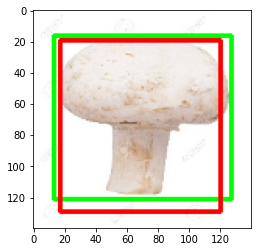

In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
with torch.no_grad():
  image, gt_bbox = validset[1] #(c,h,w)
  image = image.unsqueeze(0).to(DEVICE) #(bs,c,h,w)
  out_bbox = model(image)
  compare_plots(image, gt_bbox, out_bbox)